<a href="https://colab.research.google.com/github/eTcilopp/temp_python_intro_course_gb/blob/master/transfer_learning/GB37_homework_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №3

Реализуйте классификацию эмоциональной окрашенности текстов при помощи объекта pipeline.

1. Найдите тип задач Sentiment Analysis на huggingface.co
2. Найдите модель для русского языка (примеры: rubert-tiny2..., rubert-base...)
3. Выполните следующую ячейку. Если вы правильно инициализировали pipeline, вы получите относительно верные предсказания.

classifier( ["Отличный товар",<br>
            "Мне не понравилось",<br>
            "Прекрасно выглядит, ничего не меняйте!",<br>
            "Ничего не понял",<br>
            "У меня не работала розетка, в остальном все отлично"] )

# Решение
Я случайным образом выбрал русскоязычную модель, определяющую токсичность комментариев. <br>
Ссылка на модель приведена ниже

https://huggingface.co/cointegrated/rubert-tiny-toxicity

На странице модели подробно описано, как ее запустить в Jupyter Notebook <br>
Я скопировал код устновки

In [1]:
!pip install transformers sentencepiece --quiet

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd

In [34]:
model_checkpoint = 'cointegrated/rubert-tiny-toxicity'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()

Оттуда же взята фукнция для анализа отдельных комментариев

In [36]:
def text2toxicity(text, aggregate=True):
    """ Calculate toxicity of a text (if aggregate=True) or a vector of toxicity aspects (if aggregate=False)"""
    if not isinstance(text, str):
        return
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba

Сформировал pipeline

In [35]:
comment_analysis = pipeline('comment-classification', model=model, tokenizer=tokenizer, device=0)

... и запустил в нее список отзывов из домашнего задания.<br>
Все отзывы признаны нетоксичными

In [37]:
comment_analysis(["Отличный товар",
            "Мне не понравилось",
            "Прекрасно выглядит, ничего не меняйте!",
            "Ничего не понял",
            "У меня не работала розетка, в остальном все отлично"])

[{'label': 'non-toxic', 'score': 0.9998286962509155},
 {'label': 'non-toxic', 'score': 0.9997503161430359},
 {'label': 'non-toxic', 'score': 0.9992654919624329},
 {'label': 'non-toxic', 'score': 0.9997246861457825},
 {'label': 'non-toxic', 'score': 0.9998869895935059}]

Далее, через Google-сервис поиска датасетов нашел русскоязычную модель разных комментариев из соц. сетей. <br>Данная модель не связана с датастом

Ссылка на датасет <br>
https://data.mendeley.com/datasets/fktgy52645/1

Сформировал датафрейм из файла. Комментарии сразу начали радовать...

In [38]:
df = pd.read_csv('/content/sample_data/combined.csv')
df.head(2)

,Unnamed: 0,source,text,message,sex,decent,moral,person
0,0.0,https://vk.com/wall409928036_9302,NaN,Ты долбаеб,male,obscene,moral,person
1,1.0,https://vk.com/wall409928036_9302,NaN,Ты пидр,male,obscene,immoral,person


Первые 10 комментариев вытащил из датасета и в виде списка "скормил" сети.

In [39]:
comment_analysis(df['message'].to_list()[:10])

[{'label': 'insult', 'score': 0.9976024031639099},
 {'label': 'insult', 'score': 0.998201847076416},
 {'label': 'non-toxic', 'score': 0.9232109785079956},
 {'label': 'insult', 'score': 0.9437145590782166},
 {'label': 'non-toxic', 'score': 0.9994542002677917},
 {'label': 'non-toxic', 'score': 0.9930651187896729},
 {'label': 'insult', 'score': 0.9986327290534973},
 {'label': 'non-toxic', 'score': 0.8525521755218506},
 {'label': 'insult', 'score': 0.9979945421218872},
 {'label': 'non-toxic', 'score': 0.9841513633728027}]

Далее, добавил к датасету столбец с уровнем токсичности комментария

In [41]:
df['toxicity'] = df['message'].apply(lambda x: text2toxicity(x, True))

In [31]:
df.head(2)

,Unnamed: 0,source,text,message,sex,decent,moral,person,toxicity
0,0.0,https://vk.com/wall409928036_9302,NaN,Ты долбаеб,male,obscene,moral,person,0.999721
1,1.0,https://vk.com/wall409928036_9302,NaN,Ты пидр,male,obscene,immoral,person,0.999677


Далее, с помощью Gemini получил код для построения гистограммы токсичности с разбивкой по полу

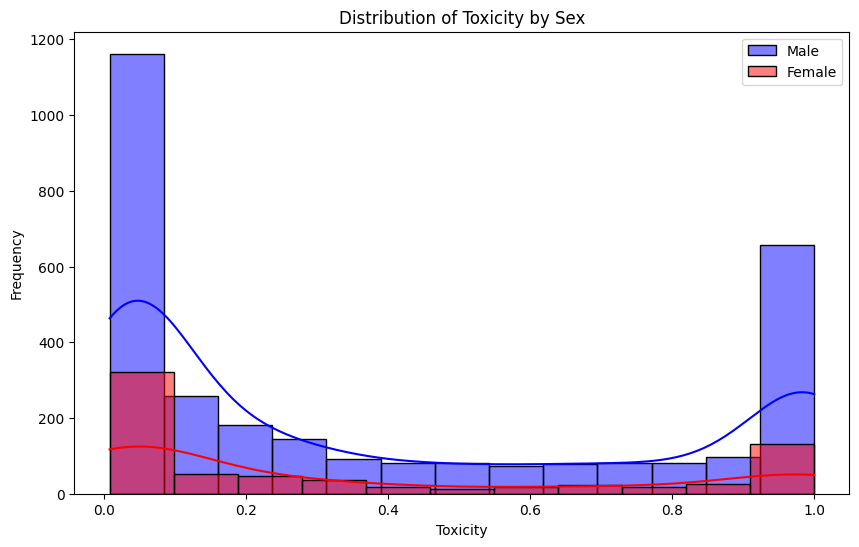

In [32]:
# prompt: create a histogram of toxicity for 2 groups based on sex

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'sex' column exists in your DataFrame and contains values like 'male' and 'female'
male_toxicity = df[df['sex'] == 'male']['toxicity']
female_toxicity = df[df['sex'] == 'female']['toxicity']

plt.figure(figsize=(10, 6))
sns.histplot(male_toxicity, label='Male', kde=True, color='blue', alpha=0.5)
sns.histplot(female_toxicity, label='Female', kde=True, color='red', alpha=0.5)
plt.xlabel('Toxicity')
plt.ylabel('Frequency')
plt.title('Distribution of Toxicity by Sex')
plt.legend()
plt.show()


Наблюдаем бимодальное распределение <br>
Большинство комментариев не являются "токсичными"<br>
Мужчины явно представлены лучше в данном датасете